## **CS_T0828_HW1**


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

import time
import os
import PIL.Image as Image
from IPython.display import display

dataset_dir = "/content/drive/My Drive/CS_T0828_HW1/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


Setup training dataset and testing dataset

In [3]:
train_transform = transforms.Compose([transforms.Resize((400, 400)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((400, 400)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

traindataset = torchvision.datasets.ImageFolder(root=dataset_dir+'train', transform=train_transform)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=32, shuffle=True, num_workers=2)

testdataset = torchvision.datasets.ImageFolder(root=dataset_dir+'test', transform=test_transform)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=2)


Use pretrained resnet34 model

In [4]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Training model

In [5]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5): 
  losses = []
  accuracies = []
  test_accuracies = []
  # set the model to train mode initially
  model.train()
  for epoch in range(n_epochs):
    since = time.time()
    running_loss = 0.0
    running_correct = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs and assign them to cuda
      inputs, labels = data
      optimizer.zero_grad()
      inputs = Variable(inputs).to(device)
      labels = Variable(labels).to(device)

      # forward + backward + optimize
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # calculate the loss/acc later
      running_loss += loss.item()
      running_correct += (labels == predicted).sum().item()

    epoch_duration = time.time()-since
    epoch_loss = running_loss/len(trainloader)
    epoch_acc = 100/32*running_correct/len(trainloader)
    print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
    
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    # switch the model to eval mode to evaluate on test data
    test_acc = eval_model(model)
    test_accuracies.append(test_acc)
    # re-set the model to train mode after validating
    model.train()
    scheduler.step(test_acc)
    since = time.time()
  print('Finished Training')
  return model, losses, accuracies, test_accuracies

Evaluate model

In [6]:
def eval_model(model_ev):
  correct = 0.0
  total = 0.0
  model_ev.eval()
  with torch.no_grad():
    for i, data in enumerate(testloader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = model_ev(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

Start training model and evaluating on the testing dataset

In [7]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 2285 s, loss: 3.7347, acc: 19.3452
Accuracy of the network on the test images: 41 %
Epoch 2, duration: 362 s, loss: 1.4569, acc: 61.6270
Accuracy of the network on the test images: 61 %
Epoch 3, duration: 362 s, loss: 0.7945, acc: 78.4921
Accuracy of the network on the test images: 66 %
Epoch 4, duration: 361 s, loss: 0.5085, acc: 86.2798
Accuracy of the network on the test images: 67 %
Epoch 5, duration: 361 s, loss: 0.3547, acc: 90.3274
Accuracy of the network on the test images: 78 %
Epoch 6, duration: 362 s, loss: 0.2458, acc: 93.0853
Accuracy of the network on the test images: 77 %
Epoch 7, duration: 362 s, loss: 0.1876, acc: 94.9802
Accuracy of the network on the test images: 84 %
Epoch 8, duration: 361 s, loss: 0.1411, acc: 96.1111
Accuracy of the network on the test images: 86 %
Epoch 9, duration: 361 s, loss: 0.1095, acc: 96.9940
Accuracy of the network on the test images: 86 %
Epoch 10, duration: 362 s, loss: 0.0603, acc: 98.5218
Accuracy of the network on 

Save trained model

In [8]:
#torch.save(model_ft, '/content/drive/My Drive/CS_T0828_HW1/model.pth')
torch.save(model_ft, '/content/drive/My Drive/CS_T0828_HW1/model_resnet50.pth')

Text(0.5, 1.0, 'Test acc')

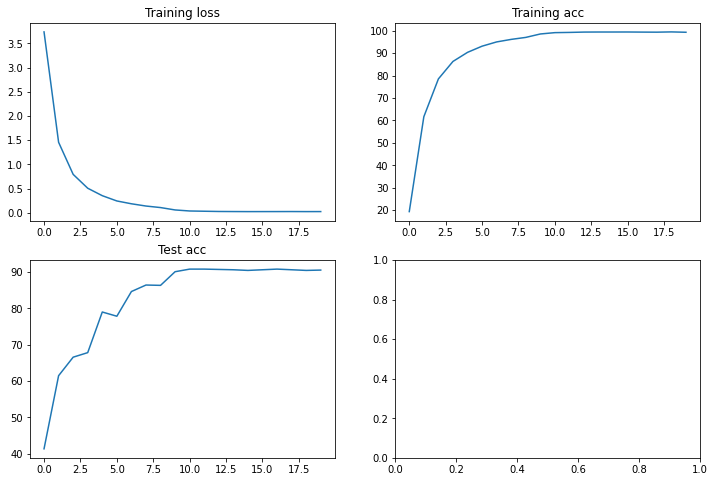

In [9]:
# plot the stats

f, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

Start inference

In [10]:
# tie the class indices to their names
def find_classes(dir):
  classes = os.listdir(dir)
  classes.sort()
  classes = ['Ram C/V Cargo Van Minivan 2012' if i=='Ram C V Cargo Van Minivan 2012' else i for i in classes]
  class_to_idx = {classes[i]: i for i in range(len(classes))}
  return classes, class_to_idx
  
classes, c_to_idx = find_classes(dataset_dir+'train')

# Find the filnames in testing dataset
def find_filename(dir):
  filename_test = os.listdir(dir)
  filename_test.sort()
  for f in range(0, len(filename_test)):
    filename_test[f] = filename_test[f].strip().strip('.jpg')
  return filename_test

filename_test = find_filename(dataset_dir+'cs-t0828-2020-hw1/testing_data/testing_data')

In [11]:
# Inference
import csv


def predict():
  #model = torch.load('/content/drive/My Drive/CS_T0828_HW1/model.pth')
  model = torch.load('/content/drive/My Drive/CS_T0828_HW1/model_resnet50.pth')
  model.eval()

  test_transform = transforms.Compose([transforms.Resize((400, 400)),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  testdataset = torchvision.datasets.ImageFolder(root=dataset_dir+'cs-t0828-2020-hw1/testing_data', transform=test_transform)
  testloader = torch.utils.data.DataLoader(testdataset, batch_size=25, shuffle=False, num_workers=2)

  counter = 0
  #with open('/content/drive/My Drive/CS_T0828_HW1/predict.csv', 'w', newline='') as csvfile:
  with open('/content/drive/My Drive/CS_T0828_HW1/predict2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for i, data in enumerate(testloader, 0): 
      images, labels = data
      images = images.to(device)

      outputs = model(images)
      conf, predicted = torch.max(outputs.data, 1)
      for c in predicted:  
        writer.writerow([filename_test[counter], classes[c.item()]])
        counter+=1
      print('step: ',i)
  print('The number of testing images: ', counter)

In [ ]:
predict()